------

This is the coursework for the UCL CASA Module Data Science for Spatial Systems module(CASA0006).

[Jupyter Notebook Code]()  &  [Data Files]()

Words count: 2,095

------

Exploring the Impact of the Seed Enterprise Investment Scheme(SEIS) on London's Start-Up Ecosystem: An Causal Inference Analysis from 2004 to 2019

------

[1-Introduction](#section1) | [2-Literature Review](#section2) | [3-Research Question](#section3) | [4-Presentation of Data](#section4) | [5-Methodology](#section5) | [6-Results](#section6) | [7-Discussion](#section7) | [8-Conclusion](#section8) | [Bibliography](#section9) | [Appendix](#section10)

------

# <a id="section1"></a> 1 | Introduction

This paper aims to investigate the impact of the Seed Enterprise Investment Scheme (SEIS) on the development and nurturing of businesses in London. Specifically, it explores whether the introduction of SEIS in 2012 has provided positive assistance to start-up enterprises in London. To achieve this, we employ casual inference methods to analyze Business Demographics and Survival Rates data for the period 2002 to 2021.

The data used in this analysis is the London Business Demographics and Survival Rates from the [London Datastore](https://data.london.gov.uk/). The data is available at the following link: [https://data.london.gov.uk/dataset/business-demographics-and-survival-rates-borough](https://data.london.gov.uk/dataset/business-demographics-and-survival-rates-borough), containing all the data of enterprise births, deaths, active enterprises and survival rates across boroughs from 2002 to 2021. And other data sources include some domestics economic metrics like [GDP growth rate](https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ihyp/pn2), [employment rate](https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/timeseries/lf24/lms), [CPI](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/d7g7/mm23), etc, from the [Office for National Statistics](https://www.ons.gov.uk/).

In [95]:
# import all the necessary libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium
import contextily as ctx
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import chi2
import numpy as np
import os
import glob

# <a id="section2" class="Title-1"></a> 2 | Literature Review

It is crucial for policy-makers to make proper incentives for businesses, especially startups, to enhance not only incubation capabilities of innovative enterprises(Elmansori, 2014), but also resilience in the face of economic crises(Berry, 2020).

Seed Enterprise Investment Scheme (SEIS), established in 2012, is a UK government initiative designed to stimulate economic growth and foster innovation by encouraging private investors to buy stakes in smaller businesses. Consequently, the effectiveness of government policies in fostering entrepreneurship and supporting small businesses has been a topic of interest in economic studies(Baldock and Mason, 2015), (Barkoczy and Wilkinson, 2019b).

Additionally, casual inference methods, including panel regression, difference-in-differences and regression discontinuity, have been widely used in evaluating the effectiveness of policy interventions, such as public health(Glass et al., 2013), environmental projects(Ferraro, 2009), school bullying prevention(Hall, 2017), and others.

These methods allow researchers to estimate the causal effects of policies by comparing outcomes for treated and untreated groups. However, most of the concentrations are focused on the comparative analysis of SEIS and other incentives in different regions all over the world(Barkoczy and Wilkinson, 2019a), instead of the casual effects brought from SEIS.


# <a id="section3" class="Title-1"></a> 3 | Research Question

Even though government policies do play a vital role in shaping the entrepreneurial ecosystem, the key factor for a startup's surviving should still be the macroeconomic environment including supply-demand equilibrium, industry potential, and local currency. 

Therefore, it is essential to exclude all of those factors off when evaluating the effectiveness of SEIS policies, seeking to unravel the extent to which this policy initiative has influenced the birth rates and survival rates of enterprises, furtherly in the different boroughs.

With these objectives in mind, we formulate the following research questions:

- RQ1: Did enterprise birth rates and survival rates largely improved since 2012?

- RQ2: Is it the introduction of SEIS in 2012 which brought better business environment for start-up enterprises in London??

- RQ3: Which borough in London experienced the most significant increase in start-up activity after the implementation of SEIS in 2012?

# <a id="section4" class="Title-1"></a> 4 | Presentation of Data

## Data Description

There are four datasets used in this analysis:

- London Boroughs(.gpkg): Accessed from London Datastore, this geopackage dataset contains information about the 32 boroughs in London, including the name of the borough, the area it covers.

- Business Demographics(.csv): This dataset contains information about the number of active enterprises, along with births and deaths rates from 2004 to 2022.

- Business Survival Rates(.csv): active enterprises, and survival rates across boroughs from 2002 to 2021.

- Domestic Economy(.csv): This dataset contains information about the [GDP growth rate](https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ihyp/pn2), [employment rate](https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/timeseries/lf24/lms), [CPI](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/d7g7/mm23), and [morgage interest rate](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/czcr/mm23) from 2004 to 2019.

In [96]:
# reading All data and have a look
# read London Boroug gpkg file
LondonBorough = gpd.read_file('Data/London_Boroughs.gpkg')

# read London Business Demographics data
Demographic = pd.read_csv('Data/business-demographics.csv')

# read London Business Survival Rates data
Survival = pd.read_csv('Data/business-survival-rates.csv')

# read economic stats data
Economic = pd.read_csv('Data/economic.csv')

In [97]:
Economic.sample(5)

,year,employment,GDP,CPI,Morgage
8,2009,70.9,-4.6,2.2,-42.4
1,2002,72.7,1.8,1.3,-11.9
19,2020,75.0,-10.4,0.9,-5.6
17,2018,75.4,1.4,2.5,3.6
13,2014,72.8,3.2,1.5,0.0


In [98]:
LondonBorough.sample(5)

,objectid,name,gss_code,hectares,nonld_area,ons_inner,sub_2011,geometry
28,29,Islington,E09000019,1485.664,0.000,T,Central,"POLYGON ((529153.600 185861.400, 529144.800 18..."
2,3,Bromley,E09000006,15013.487,0.000,F,South,"POLYGON ((540373.600 157530.400, 540361.200 15..."
11,12,Greenwich,E09000011,5044.190,310.785,F,East,"POLYGON ((538102.400 176312.700, 538078.800 17..."
10,11,Lewisham,E09000023,3531.706,16.795,T,East,"POLYGON ((535843.800 174919.500, 535847.300 17..."
12,13,Bexley,E09000004,6428.649,370.619,F,East,"POLYGON ((547448.000 170380.300, 547429.200 17..."


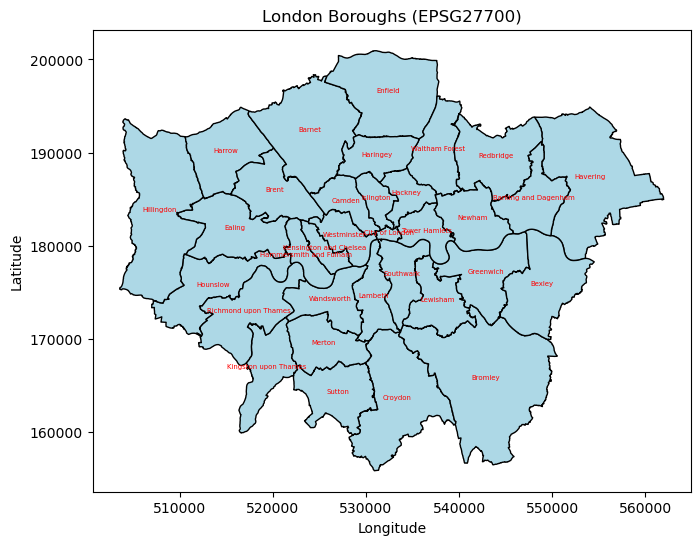

In [99]:
# plot the map of London Boroughs and mark the name of each Borough
fig, ax = plt.subplots(figsize=(8, 6))
LondonBorough.plot(ax=ax, color='lightblue', edgecolor='k')
for x, y, label in zip(LondonBorough.geometry.centroid.x, LondonBorough.geometry.centroid.y, LondonBorough['name']):
    ax.text(x, y, label, fontsize=5, ha='center', color='red')
plt.title('London Boroughs (EPSG27700)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [100]:
#Demographic.sample(5)

In [101]:
#Demographic.info()

In [102]:
# name the first column as 'code' in Demographic data
Demographic.columns = ['code', *Demographic.columns[1:]]

In [103]:
#Survival.sample(5)

## Data Preprocessing

### Merging the datasets



The Business Demographics and Survival Rates datasets were merged based on the borough 'name' and 'year' to create a comprehensive dataset for analysis.

In [104]:
#first we need to merge the Demographic and Survival data based on the 'code' and 'year' columns
# merge the Demographic and Survival data
Business = pd.merge(Demographic, Survival, on=['code', 'year'])
#Business.sample(5)

### Cleaning the data



The data was cleaned to remove any odd values and outliers that could affect the analysis. Also, the study period was limited to 2004-2019 to ensure consistency across the datasets and eliminate the impact of Covid-19 pandemic since 2020. And clean the columns to drop the redundant ones.

In [105]:
# clean the data by filling all the ":" value with NaN
Business = Business.replace(':', pd.NA)

# convert all the columns to numeric
Business = Business.apply(pd.to_numeric, errors='ignore')

In [106]:
# drop the columns 'area_y', 'births_y'. and change column name 'area_x' to 'area' and 'births_x' to 'births'
Business = Business.drop(columns=['area_y', 'births_y'])
Business = Business.rename(columns={'area_x': 'area', 'births_x': 'births'})

In [107]:
# drop the less useful columns
drop_columns = ['births', 'deaths', '1_year_survival_number', 
                '1_year_survival_number', '2_year_survival_number', '3_year_survival_number', 
                '4_year_survival_number', '5_year_survival_number', 
                '4_year_survival_rate', '5_year_survival_rate']
Business = Business.drop(columns=drop_columns)

In [108]:
# drop all rows where year is 2002, 2003, 2020, 2021 and 2022
Business0419 = Business[(Business['year'] != '2002') & (Business['year'] != '2003') & (Business['year'] != '2019') & (Business['year'] != '2020') & (Business['year'] != '2021') & (Business['year'] != '2022')]

In [109]:
# change the 'year' to interger type
Business0419['year'] = Business0419['year'].astype(int)

In [110]:
# merge the Economic data with the Business0419 data
DF = pd.merge(Business0419, Economic, on=['year'])

In [111]:
DF.sample(5)

,code,area,year,active_enterprises,birth_rate,death_rate,1_year_survival_rate,2_year_survival_rate,3_year_survival_rate,employment,GDP,CPI,Morgage
12,E09000013,Hammersmith and Fulham,2004,10745,17.4,14.3,93.3,70.5,52.8,72.9,2.4,1.3,22.5
644,E09000033,Westminster,2016,53045,12.9,9.5,95.6,77.5,62.6,74.2,1.9,0.7,-3.1
515,E09000006,Bromley,2014,14825,14.8,9.6,93.2,78.1,64.2,72.8,3.2,1.5,0.0
265,E09000011,Greenwich,2009,6695,13.7,14.5,93.5,75.5,59.2,70.9,-4.6,2.2,-42.4
640,E09000029,Sutton,2016,9140,15.0,9.7,94.9,74.2,59.6,74.2,1.9,0.7,-3.1


### Dividing the data


The data was divided into two groups: national level and borough level.The national level data was prepared for causal inference to analyze the overall impact of SEIS on UK, while the boroughs level data was used to compare the degree of that impact of SEIS on individual boroughs.

In [112]:
# select all the rows where 'code' is not start with 'E09'
nation = DF[~DF['code'].str.startswith('E09')]
nation.sample(4)

,code,area,year,active_enterprises,birth_rate,death_rate,1_year_survival_rate,2_year_survival_rate,3_year_survival_rate,employment,GDP,CPI,Morgage
35,E12000001,North East,2004,56855,13.4,11.3,93.5,76.9,64.4,72.9,2.4,1.3,22.5
43,E12000009,South West,2004,196850,12.2,10.5,94.6,81.4,68.9,72.9,2.4,1.3,22.5
815,K02000001,United Kingdom,2019,2889115,12.6,10.5,94.6,74.6,55.9,75.8,1.6,1.8,3.1
294,E12000005,West Midlands,2009,191550,9.5,12.1,91.6,73.6,59.2,70.9,-4.6,2.2,-42.4


In [113]:
# select all the rows where 'area' is 'London'
London = DF[DF['area'] == 'London']
London.sample(4)

,code,area,year,active_enterprises,birth_rate,death_rate,1_year_survival_rate,2_year_survival_rate,3_year_survival_rate,employment,GDP,CPI,Morgage
398,E12000007,London,2011,421185,14.6,10.3,92.1,73.6,58.0,70.3,1.1,4.5,3.1
806,E12000007,London,2019,597720,14.8,11.4,94.3,73.2,55.5,75.8,1.6,1.8,3.1
551,E12000007,London,2014,500825,17.7,10.6,90.9,73.7,58.9,72.8,3.2,1.5,0.0
143,E12000007,London,2006,363630,13.2,10.7,95.9,78.8,63.7,72.8,2.4,2.3,8.1


In [114]:
# select all thw rows where 'code' is start with 'E09', which means London Boroughs
borough = DF[DF['code'].str.startswith('E09')]
borough.sample(4)

,code,area,year,active_enterprises,birth_rate,death_rate,1_year_survival_rate,2_year_survival_rate,3_year_survival_rate,employment,GDP,CPI,Morgage
12,E09000013,Hammersmith and Fulham,2004,10745,17.4,14.3,93.3,70.5,52.8,72.9,2.4,1.3,22.5
225,E09000022,Lambeth,2008,11305,16.4,10.7,88.9,68.6,50.4,72.6,-0.2,3.6,-0.3
677,E09000015,Harrow,2017,16695,13.3,12.2,93.9,74.1,58.6,74.8,2.7,2.7,-4.4
207,E09000004,Bexley,2008,6920,11.5,10.7,95.0,74.5,59.1,72.6,-0.2,3.6,-0.3


### Descriptive Statistics

The descriptive statistics is not shown as the codes are commented, because the time-series patterns would be more informative in the Visualization sections.

In [115]:
# descriptive statistics of the London data
borough.describe()

,year,active_enterprises,birth_rate,death_rate,1_year_survival_rate,2_year_survival_rate,3_year_survival_rate,employment,GDP,CPI,Morgage
count,594.0000,594.000000,594.000000,594.000000,594.000000,561.000000,528.000000,594.000000,594.000000,594.000000,594.000000
mean,2012.5000,14424.520202,15.212121,11.676431,92.655219,73.863815,57.787689,73.016667,1.288889,2.205556,1.461111
std,5.1925,8354.157823,3.044280,1.684755,4.109933,4.616398,4.720047,1.677801,3.675498,1.048352,13.404825
min,2004.0000,3120.000000,8.300000,6.800000,60.500000,46.800000,33.400000,70.300000,-10.400000,0.000000,-42.400000
25%,2008.0000,9661.250000,13.125000,10.500000,92.100000,71.800000,55.300000,71.500000,1.400000,1.500000,-2.300000
50%,2012.5000,12582.500000,14.800000,11.500000,93.700000,74.100000,57.900000,72.850000,2.050000,2.300000,1.400000
75%,2017.0000,16247.500000,16.700000,12.500000,94.900000,76.800000,60.800000,74.700000,2.600000,2.700000,3.600000
max,2021.0000,56610.000000,37.400000,21.300000,100.000000,88.200000,70.200000,75.800000,8.700000,4.500000,23.500000


In [116]:
# descriptive statistics of the nation data
nation.describe()

,year,active_enterprises,birth_rate,death_rate,1_year_survival_rate,2_year_survival_rate,3_year_survival_rate,employment,GDP,CPI,Morgage
count,324.000000,3.240000e+02,324.000000,324.000000,324.000000,306.000000,288.000000,324.000000,324.000000,324.000000,324.000000
mean,2012.500000,6.945956e+05,12.307716,10.352778,92.904012,74.904902,59.581944,73.016667,1.288889,2.205556,1.461111
std,5.196152,9.161002e+05,2.001432,1.203925,2.650057,3.750428,4.260018,1.678981,3.678083,1.049089,13.414254
min,2004.000000,5.182500e+04,6.500000,6.500000,81.400000,62.200000,45.000000,70.300000,-10.400000,0.000000,-42.400000
25%,2008.000000,1.670838e+05,11.000000,9.700000,92.100000,72.625000,56.700000,71.500000,1.400000,1.500000,-2.300000
50%,2012.500000,2.308625e+05,12.300000,10.400000,93.650000,74.750000,59.650000,72.850000,2.050000,2.300000,1.400000
75%,2017.000000,4.543188e+05,13.400000,11.100000,94.525000,77.000000,62.300000,74.700000,2.600000,2.700000,3.600000
max,2021.000000,2.939675e+06,19.200000,13.700000,97.000000,83.800000,71.100000,75.800000,8.700000,4.500000,23.500000


## Visualization and Preliminary Comparative Analysis

In [117]:
# add the London dataframe to the London Boroughs geodataframe based on the 'code' column in London and 'gss_code' column in London Boroughs
gdf_borough = LondonBorough.merge(borough, left_on='gss_code', right_on='code')

In [118]:
# change the 'year' column type to interger
gdf_borough['year'] = gdf_borough['year'].astype(int)

In [119]:
nation.sample(5)

,code,area,year,active_enterprises,birth_rate,death_rate,1_year_survival_rate,2_year_survival_rate,3_year_survival_rate,employment,GDP,CPI,Morgage
355,K03000001,Great Britain,2010,2292440,10.1,10.6,86.7,72.5,57.1,70.4,2.2,3.3,0.5
603,E12000008,South East,2015,420270,13.2,10.0,90.6,73.0,58.4,73.6,2.2,0.0,-0.4
251,N92000002,Northern Ireland,2008,60030,9.4,7.0,81.4,63.4,50.5,72.6,-0.2,3.6,-0.3
187,E13000002,Outer London,2007,181025,13.9,11.3,95.9,80.0,60.1,72.7,2.6,2.3,23.5
146,E92000001,England,2006,1924485,11.7,9.5,96.5,80.7,66.2,72.8,2.4,2.3,8.1


In [120]:
# drop some columns that are not useful
drop_columns_2 = ['hectares', 'nonld_area', 'ons_inner', 'sub_2011', 'code', 'area']
gdf_borough = gdf_borough.drop(columns=drop_columns_2)

In [121]:
#gdf_borough.sample(2)

### Birth Rates

Let's visualize the boroughs' data to compare the birth rates in 2011 and 2013, just before and after the introduction of SEIS in 2012.

In [122]:
#sub the geodataframe to only include the rows where 'year' = 2011, and 'year'=2013
gdf_borough2010 = gdf_borough[gdf_borough['year'] == 2010]
gdf_borough2011 = gdf_borough[gdf_borough['year'] == 2011]
gdf_borough2012 = gdf_borough[gdf_borough['year'] == 2012]
gdf_borough2013 = gdf_borough[gdf_borough['year'] == 2013]

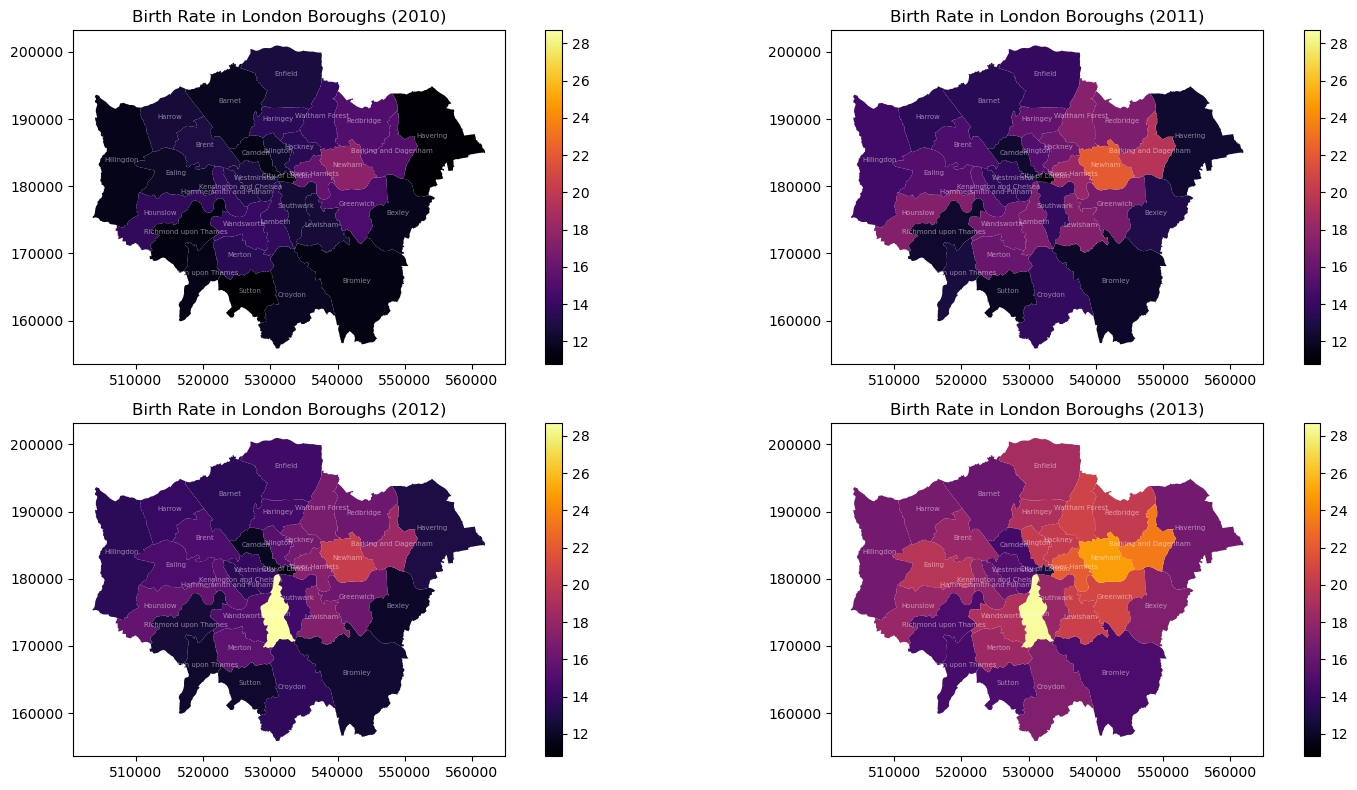

In [123]:
# plot the map of London Boroughs in 2010, 2011, 2012 and 2013, based on the 'birth_rate' column

# Determine the range of birth_rate values
min_birth_rate = min(gdf_borough2010['birth_rate'].min(), gdf_borough2011['birth_rate'].min(), gdf_borough2012['birth_rate'].min(), gdf_borough2013['birth_rate'].min())
max_birth_rate = max(gdf_borough2010['birth_rate'].max(), gdf_borough2011['birth_rate'].max(), gdf_borough2012['birth_rate'].max(), gdf_borough2013['birth_rate'].max())

fig, axs = plt.subplots(2, 2, figsize=(16, 8))

gdf_borough2010.plot(ax=axs[0, 0], column='birth_rate', cmap='inferno', legend=True, vmin=min_birth_rate, vmax=max_birth_rate)
axs[0, 0].set_title('Birth Rate in London Boroughs (2010)')
for idx, row in gdf_borough2010.iterrows():
    axs[0, 0].text(s=row['name'], x=row['geometry'].centroid.x, y=row['geometry'].centroid.y, horizontalalignment='center', fontsize='5', color='white', alpha=0.5)

gdf_borough2011.plot(ax=axs[0, 1], column='birth_rate', cmap='inferno', legend=True, vmin=min_birth_rate, vmax=max_birth_rate)
axs[0, 1].set_title('Birth Rate in London Boroughs (2011)')
for idx, row in gdf_borough2011.iterrows():
    axs[0, 1].text(s=row['name'], x=row['geometry'].centroid.x, y=row['geometry'].centroid.y, horizontalalignment='center', fontsize='5', color='white', alpha=0.5)

gdf_borough2012.plot(ax=axs[1, 0], column='birth_rate', cmap='inferno', legend=True, vmin=min_birth_rate, vmax=max_birth_rate)
axs[1, 0].set_title('Birth Rate in London Boroughs (2012)')
for idx, row in gdf_borough2012.iterrows():
    axs[1, 0].text(s=row['name'], x=row['geometry'].centroid.x, y=row['geometry'].centroid.y, horizontalalignment='center', fontsize='5', color='white', alpha=0.5)

gdf_borough2013.plot(ax=axs[1, 1], column='birth_rate', cmap='inferno', legend=True, vmin=min_birth_rate, vmax=max_birth_rate)
axs[1, 1].set_title('Birth Rate in London Boroughs (2013)')
for idx, row in gdf_borough2013.iterrows():
    axs[1, 1].text(s=row['name'], x=row['geometry'].centroid.x, y=row['geometry'].centroid.y, horizontalalignment='center', fontsize='5', color='white', alpha=0.5)

plt.tight_layout()
plt.show()

Obviously, the birth rates of enterprises in London have increased significantly after the introduction of SEIS in 2012. It is common that the SEIS would bring tremendous confidence for the investing market, encouraging lots of start-ups to establish their businesses in London. Therefore the research question 1 can be answered as "Yes".

### Death Rates and Survival Rates

Let's visualize the national level data by plotting the line graph.

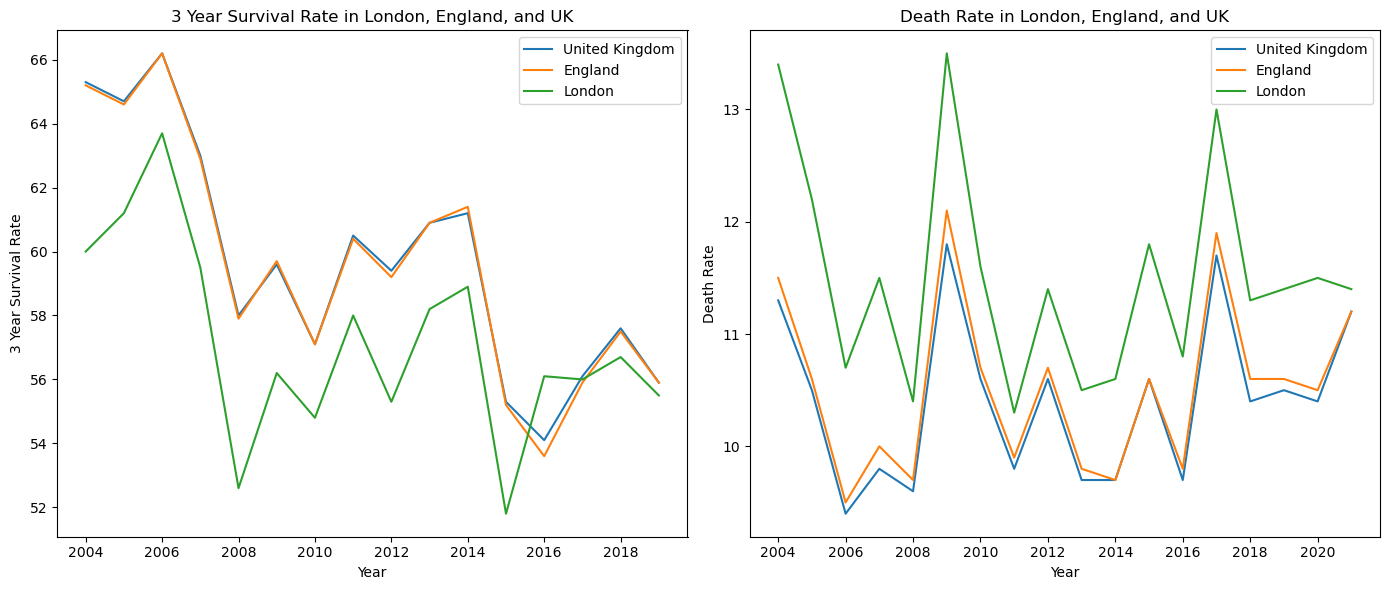

In [124]:
# plot the line graph based on the 'death_rate' column in nation data, where 'year' is the x-axis, and 'name' is 'UK' or 'England' for two lines
nation_uk = nation[nation['area'] == 'United Kingdom']
nation_england = nation[nation['area'] == 'England']
nation_london = nation[nation['area'] == 'London']

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First plot: 3 Year Survival Rate
axs[0].plot(nation_uk['year'], nation_uk['3_year_survival_rate'], label='United Kingdom')
axs[0].plot(nation_england['year'], nation_england['3_year_survival_rate'], label='England')
axs[0].plot(nation_london['year'], nation_london['3_year_survival_rate'], label='London')
axs[0].set_title('3 Year Survival Rate in London, England, and UK')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('3 Year Survival Rate')
axs[0].legend()
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Second plot: Death Rate
axs[1].plot(nation_uk['year'], nation_uk['death_rate'], label='United Kingdom')
axs[1].plot(nation_england['year'], nation_england['death_rate'], label='England')
axs[1].plot(nation_london['year'], nation_london['death_rate'], label='London')
axs[1].set_title('Death Rate in London, England, and UK')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Death Rate')
axs[1].legend()
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()

plt.show()

Moreover, in a long-term perspective, the 3_year_survival_rate of enterprises was decreasing since 2004, and a slight bounce back since 2017. However, when we look at the national level data, the death rates of enterprises just fluctuated randomly, this is mainly because of the cyclical fluctuations of the global economy. Hence, the SEIS might play a minor role in this section. 

Though, so far the preliminary analysis does not provide a clear answer to the research questions, not able to indicate whether SEIS did impact on the development of new businesses in London or not. Because there is more variables such as '1_year_survival_rate' and '5_year_survival_rate', which could be more informative to evaluate the operating environment of the start-up enterprises.

That's why we need to employ panel regression to analyze the data in a more complex and advanced way.

# <a id="section5" class="Title-1"></a> 5.Methodology

## Panel Regression on Boroughs


### Dependent Variable


According to the research questions, one important definition needs to be clarified is how we evaluate the business environment based on the existing data. We have three parts of the data, the birth rates, the death rates, and the survival rates. However, in the pael regression mode, we need to integrate all of them into one metrics, providing a comprehensive evaluation of the business environment.

After searching the relevant literature, we didn't find any existing equations or solutions to this problem. Therefore, we just simply normalize the birth rates, death rates, and survival rates, and then sum them up to get the 'Business Environment Index' as the dependent variable.

In [125]:
# create a new columne 'average_survival_rate' in London Boroughs geodataframe, which is the average of '3_year_survival_rate', '2_year_survival_rate' and '1_year_survival_rate'
gdf_borough['average_survival_rate'] = gdf_borough[['3_year_survival_rate', '2_year_survival_rate', '1_year_survival_rate']].mean(axis=1)
London['average_survival_rate'] = London[['3_year_survival_rate', '2_year_survival_rate', '1_year_survival_rate']].mean(axis=1)

# create a new column 'BEindex' by normalizing the 'birth_rate', 'death_rate' and 'average_survival_rate' columns and sum them up
gdf_borough['BEindex'] = (gdf_borough['birth_rate'] - gdf_borough['birth_rate'].min()) / (gdf_borough['birth_rate'].max() - gdf_borough['birth_rate'].min()) - \
                           (gdf_borough['death_rate'].max() - gdf_borough['death_rate']) / (gdf_borough['death_rate'].max() - gdf_borough['death_rate'].min()) + \
                           (gdf_borough['average_survival_rate'] - gdf_borough['average_survival_rate'].min()) / (gdf_borough['average_survival_rate'].max() - gdf_borough['average_survival_rate'].min())
London['BEindex'] = (London['birth_rate'] - London['birth_rate'].min()) / (London['birth_rate'].max() - London['birth_rate'].min()) - \
                            (London['death_rate'].max() - London['death_rate']) / (London['death_rate'].max() - London['death_rate'].min()) + \
                            (London['average_survival_rate'] - London['average_survival_rate'].min()) / (London['average_survival_rate'].max() - London['average_survival_rate'].min())

C:\Users\SBH\AppData\Local\Temp\ipykernel_39064\3485813137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London['average_survival_rate'] = London[['3_year_survival_rate', '2_year_survival_rate', '1_year_survival_rate']].mean(axis=1)
C:\Users\SBH\AppData\Local\Temp\ipykernel_39064\3485813137.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London['BEindex'] = (London['birth_rate'] - London['birth_rate'].min()) / (London['birth_rate'].max() - London['birth_rate'].min()) - \


In [126]:
London.sample(3)

,code,area,year,active_enterprises,birth_rate,death_rate,1_year_survival_rate,2_year_survival_rate,3_year_survival_rate,employment,GDP,CPI,Morgage,average_survival_rate,BEindex
806,E12000007,London,2019,597720,14.8,11.4,94.3,73.2,55.5,75.8,1.6,1.8,3.1,74.333333,-0.070875
92,E12000007,London,2005,359765,14.3,12.2,94.7,78.3,61.2,72.9,2.7,2.1,15.3,78.066667,0.243355
704,E12000007,London,2017,582595,14.6,13.0,93.8,72.7,56.0,74.8,2.7,2.7,-4.4,74.166667,0.389205


### Independent Variables

The independent variables include the dummy variable 'SEIS' to indicate the introduction of SEIS in 2012, in which the value is 1 after 2012 and 0 before 2012. And the 'Year' variable to control the time effect. Additionally, some other variables would be introduced as independent variables to control the potential confounding factors, such as the 'GDP annualy growth', 'Unemployment Rate', 'CPI(Consumer Price Inflation)', etc. As there might potential collinearity between these variables, we just use some typical and classical variables to control the potential confounding factors.

In [127]:
# create a dummy column 'SEIS' where 0 if 'year' is between 2004 and 2012, and 1 otherwise
London['SEIS'] = 0
gdf_borough['SEIS'] = 0
London.loc[(London['year'] < 2004) | (London['year'] > 2012), 'SEIS'] = 1
gdf_borough.loc[(gdf_borough['year'] < 2004) | (gdf_borough['year'] > 2012), 'SEIS'] = 1
gdf_borough.sample(3)

C:\Users\SBH\AppData\Local\Temp\ipykernel_39064\389441012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London['SEIS'] = 0


,objectid,name,gss_code,geometry,year,active_enterprises,birth_rate,death_rate,1_year_survival_rate,2_year_survival_rate,3_year_survival_rate,employment,GDP,CPI,Morgage,average_survival_rate,BEindex,SEIS
476,27,Camden,E09000007,"POLYGON ((528840.200 187217.800, 528834.600 18...",2012,26460,11.9,10.9,86.1,69.3,55.9,71.0,1.5,2.8,2.3,70.433333,-0.122376,0
50,3,Bromley,E09000006,"POLYGON ((540373.600 157530.400, 540361.200 15...",2018,17195,12.4,10.6,95.3,77.4,60.2,75.4,1.4,2.5,3.6,77.633333,0.022468,1
275,16,Lambeth,E09000022,"POLYGON ((533716.600 170817.800, 533715.400 17...",2009,11360,12.7,14.9,93.1,72.7,58.1,70.9,-4.6,2.2,-42.4,74.633333,0.267516,0


### Model Selection between Fixed Effects and Random Effects

We need to choose between fixed effects and random effects models. The fixed effects model is more suitable when the unobserved heterogeneity is correlated with the independent variables, while the random effects model is more suitable when the unobserved heterogeneity is uncorrelated with the independent variables.

In this paper, we will run the fixed effects model first, and then the random effects model. The Hausman test will be used to determine which model is more appropriate for the data.

Firstly, we need to reset the index of the dataframe, and then run the fixed effects model.

In [128]:
DFforPanel = gdf_borough[['name', 'year', 'gss_code', 'CPI', 'GDP', 'Morgage', 'employment', 'BEindex', 'SEIS']]
DFforPanel = DFforPanel.set_index(['name', 'year'])

#### Fixed Effects Model

In [138]:
fe_mod = PanelOLS.from_formula('BEindex ~ GDP + CPI + employment + Morgage + SEIS + EntityEffects', data=DFforPanel)
# fit the model
fe_model = fe_mod.fit()
# print the model
#print(fe_model)

#### Random Effects Model

In [139]:
# define the model's dependent and independent variables
re_mod = RandomEffects(DFforPanel.BEindex, DFforPanel[['GDP', 'CPI', 'employment', 'Morgage', 'SEIS']])

# fit the model
re_model = re_mod.fit()
# print the model's summary
#print(re_model.summary)

#### Using Hausman Test to Choose between Fixed Effects and Random Effects

In [131]:
# Extract coefficients and covariance matrices
beta_fe = fe_model.params
beta_re = re_model.params
cov_fe = fe_model.cov
cov_re = re_model.cov

# Calculate the difference and the variance of the difference
diff = beta_fe - beta_re
var_diff = cov_fe - cov_re

# Calculate the Hausman statistic
hausman_stat = diff.T @ np.linalg.inv(var_diff) @ diff

# Calculate the degrees of freedom (number of coefficients)
df = len(beta_fe)

# Calculate the p-value
p_value = 1 - chi2.cdf(hausman_stat, df)

print(f'Hausman test statistic: {hausman_stat}, p-value = {p_value}')

Hausman test statistic: 13.579937691793363, p-value = 0.018509811089435724


The Hausman test is used to determine whether the fixed effects model or the random effects model is more appropriate for the data. The p-value of the Hausman test is less than 0.05, which indicates that the **Fixed Effects Model** is more appropriate for the data.

### Assumptions



So far, we have finished all the data preparation, cleaning and modelling process. In order to validate the model results, we need to check the assumptions of the panel regression model, including the linearity, independence, homoscedasticity, and normality of the residuals. If the assumptions are met, we can proceed with the analysis.

#### 1 | Linearity: 


The relationship between the dependent and independent variables should be linear. We can check this by plotting the scatter plots of the dependent variable against each independent variable.

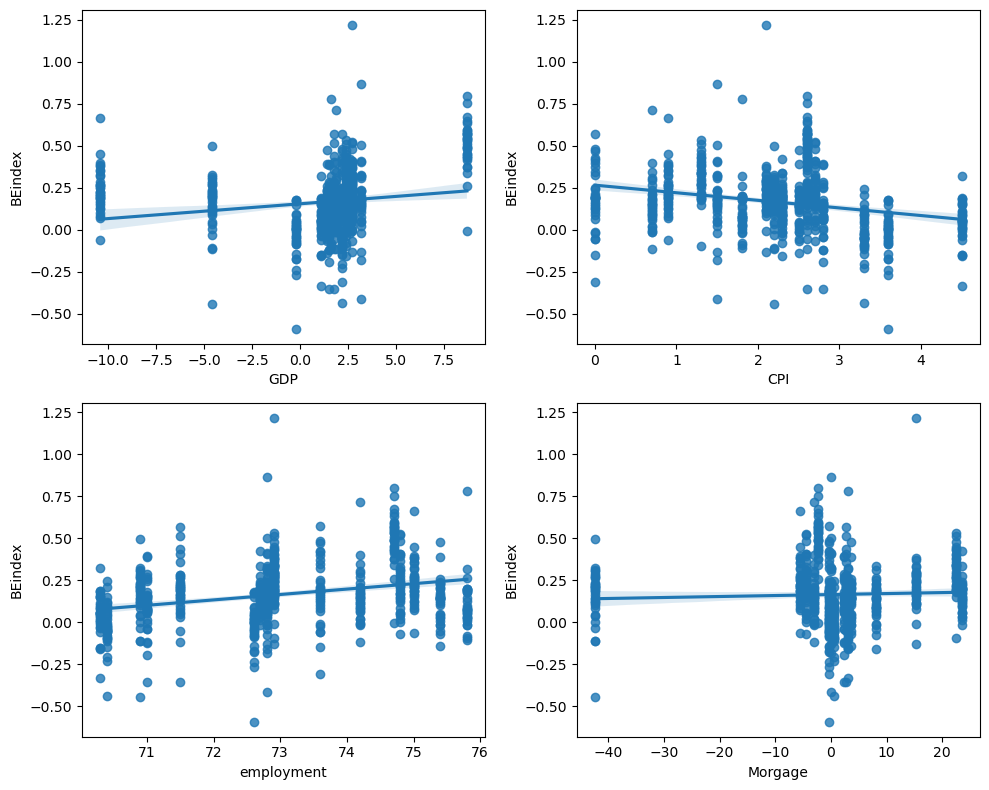

In [132]:
plt.figure(figsize=(10, 8))

# create a 2x2 grid of subplots
# first plot：GDP vs BEindex
plt.subplot(2, 2, 1) # (rows, columns, panel number)
sns.regplot(x='GDP', y='BEindex', data=DFforPanel)

# second plot：CPI vs BEindex
plt.subplot(2, 2, 2)
sns.regplot(x='CPI', y='BEindex', data=DFforPanel)

# third plot：employment vs BEindex
plt.subplot(2, 2, 3)
sns.regplot(x='employment', y='BEindex', data=DFforPanel)

# fourth plot：Morgage vs BEindex
plt.subplot(2, 2, 4)
sns.regplot(x='Morgage', y='BEindex', data=DFforPanel)

plt.tight_layout()
plt.show()

Additionally, we can also check the linearity by plotting the residuals against the predicted values. If the residuals are randomly distributed around zero, the linearity assumption is met.

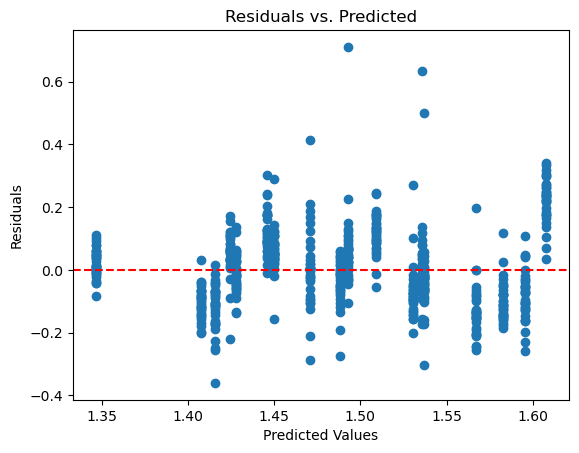

In [133]:
# fit the FE model and get the prediction
predictions = fe_model.predict()
residuals = fe_model.resids

# plot the residuals vs. predicted values
plt.scatter(predictions, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()

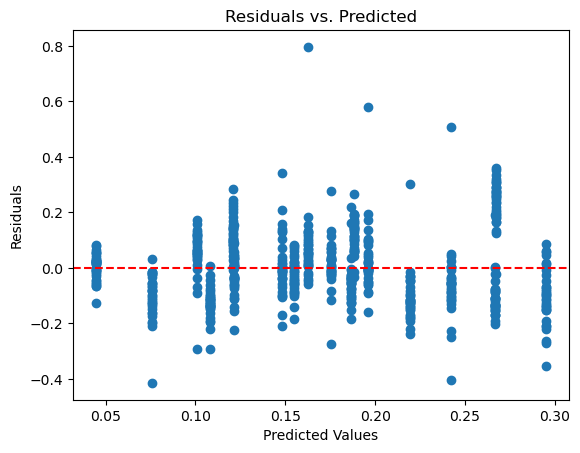

In [134]:
# fit the FE model and get the prediction
predictions = re_model.predict()
residuals = re_model.resids

# plot the residuals vs. predicted values
plt.scatter(predictions, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()

As shown in the scatter plots, the relationship between the dependent variable and the independent variables appears to be linear. The residuals are also randomly distributed around zero, indicating that the linearity assumption is met.

#### 2 | Independence: 


The error terms (residuals) in the model should be independent of each other. This assumption is particularly important in time-series or panel data.

In [136]:
durbin_watson(residuals)
# print the result of the Durbin-Watson test
print(f'Durbin-Watson test statistic: {durbin_watson(residuals)}')

Durbin-Watson test statistic: 1.3429717601497206


As the Durbain-Watson test is 1.47, indicating that there is some slight positive autocorrelation in the residuals. This is not an ideal result (ideal value close to 2), but may still be acceptable.

#### 3 | Homoscedasticity: 


The error terms in the model should have constant variance. If not, it may lead to underestimation or overestimation of the standard errors of the regression coefficients.

In [90]:
# calculate the squared residuals of the model
residuals = fe_model.resids
df_exog = gdf_borough[['GDP', 'CPI', 'employment', 'Morgage', 'SEIS']]

# run the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, sm.add_constant(df_exog))

print(f'Breusch-Pagan test: stat={bp_test[0]}, p-value={bp_test[1]}')
# if p-value is less than the significance level (e.g., 0.05), reject the null hypothesis of homoscedasticity, indicating the presence of heteroscedasticity.

Breusch-Pagan test: stat=29.614766180659466, p-value=1.7560134508006195e-05


The p-value of the Breusch-Pagan test is nearly 0.000, indicating that the residuals are heteroscedastic. This means that the standard errors of the regression coefficients may be underestimated or overestimated.

# <a id="section6" class="Title-1"></a> 6.Results

In [137]:
print(fe_model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                BEindex   R-squared:                        0.2417
Estimator:                   PanelOLS   R-squared (Between):             -40.432
No. Observations:                 594   R-squared (Within):               0.2417
Date:                Sun, Apr 07 2024   R-squared (Overall):             -27.087
Time:                        19:54:52   Log-likelihood                    388.18
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      35.451
Entities:                          33   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                   F(5,556)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robust):             35.451
                            

The R-squared(within) of the Fixed Effects Model is 0.24, which means that 24% of the variation in the dependent variable can be explained by the independent variables, which is relatively low. F-test for poolability is 17, with a p-value of 0.000, which indicates that the fixed effects model is statistically significant. Overall, the model's metrics indicate that fixed effects (entity effects) are significant, meaning there are significant differences across difference boroughs.

Especially,he coefficient of SEIS is 0.0012, but the P-value is 0.9450, indicating that while the coefficient for SEIS is positive, this relationship is not statistically significant. This means that the impact of SEIS (a dummy variable for policy implementation) on BEindex is not significant.

In conclusion, the model indicates that while GDP, CPI, employment rate, and mortgage rates have significant impacts on BEindex, but the policy variable (SEIS) does not have a significant impact. 

# <a id="section7" class="Title-1"></a> 7.Discussion

Therefore, we have to reject the null hypothesis that SEIS has a significant impact on the business environment in London, which could potentially indicate that the research question 2's answer is 'No'. Unfortunately, the research question 3 cannot be answered, even though we could itertatively run the panel regression model on each borough, but due to the limited data(only 16 observations for each borough), the results would be not reliable.

This study's findings challenge the presumed efficacy of policy initiatives like SEIS in directly influencing business environments and start-up survival in London. Despite the policy's aim to encourage investment in small businesses, its insignificance in our analysis suggests that factors beyond policy design and implementation impact start-up metrics.

Despite that there are some limitations in this study, such as the rigid definition of 'BEindex', the potential collinearity between the independent variables, and omitted complex interaction among ecosystems, the results still provide valuable insights into the nuanced relationship between policy and business outcomes. All the research process could also underscores the complexity of economic ecosystems and the various factors influencing enterprise success, from macroeconomic conditions to local market dynamics. 

# <a id="section8" class="Title-1"></a> 8.Conclusion

Again, the three questions raised should be answered as follows:

RQ1: Enterprise birth rates do have largely improved since 2012.

RQ2: Statistically speaking, the introduction of SEIS in 2012 did not bring a better business environment for start-up enterprises in London.

RQ3: The borough in London that experienced the most significant increase in start-up activity after the implementation of SEIS in 2012 require more deep exploration analysis to be determined.

The analysis conducted in this paper reveals the nuanced and complex nature of policy impacts on business ecosystems, particularly in urban environments like London. While SEIS showed potential as a policy tool to stimulate start-up activity, its direct effects on business demographics and survival rates were not statistically significant. 

This outcome invites a broader consideration of how policies are designed and implemented, suggesting a need for multi-faceted approaches that consider local economic conditions, industry-specific needs, and the global economic context. Future research should explore the indirect effects of policies like SEIS, including changes in investor behavior, sector-specific impacts, and long-term shifts in entrepreneurial culture. Additionally, comparative studies between boroughs with similar schemes could offer insights into the nuanced ways policy can shape business landscapes.

# <a id="section9" class="Title-1"></a> Bibliography


Baldock, R. and Mason, C. (2015). 'Establishing a new UK finance escalator for innovative SMEs: the roles of the Enterprise Capital Funds and Angel Co-Investment Fund'. Venture Capital. Routledge, 17 (1-2), pp. 59-86. doi: 10.1080/13691066.2015.1021025.

Barkoczy, S. and Wilkinson, T. (2019a). 'Establishing a Comparative Framework of Tax Incentives for Start-Up Investors'. in Barkoczy, S. and Wilkinson, T. (eds) Incentivising Angels: A Comparative Framework of Tax Incentives for Start-Up Investors. Singapore: Springer, pp. 1-9. doi: 10.1007/978-981-13-6632-1_1.

Barkoczy, S. and Wilkinson, T. (2019b). 'United Kingdom's Seed Enterprise Investment Scheme'. in Barkoczy, S. and Wilkinson, T. (eds) Incentivising Angels: A Comparative Framework of Tax Incentives for Start-Up Investors. Singapore: Springer, pp. 81-98. doi: 10.1007/978-981-13-6632-1_5.

Berry, C. (2020). 'From Receding to Reseeding: Industrial Policy, Governance Strategies and Neoliberal Resilience in Post-crisis Britain'. New Political Economy. Routledge, 25 (4), pp. 607-625. doi: 10.1080/13563467.2019.1625316.

Elmansori, E. (2014). Fostering Innovation and Entrepreneurship in Small and Medium Enterprises (SMEs) Through Business Incubators in the Arab World. Ph.D. Nottingham Trent University (United Kingdom). Available at: https://www.proquest.com/docview/2399409774/abstract/66ECDA0487A84BCBPQ/1 (Accessed: 5 April 2024).

Ferraro, P. J. (2009). 'Counterfactual thinking and impact evaluation in environmental policy'. New Directions for Evaluation, 2009 (122), pp. 75-84. doi: 10.1002/ev.297.

Glass, T. A., Goodman, S. N., Hernán, M. A. and Samet, J. M. (2013). 'Causal Inference in Public Health'. Annual Review of Public Health, 34 (1), pp. 61-75. doi: 10.1146/annurev-publhealth-031811-124606.

Hall, W. (2017). 'The Effectiveness of Policy Interventions for School Bullying: A Systematic Review'. Journal of the Society for Social Work and Research. The University of Chicago Press, 8 (1), pp. 45-69. doi: 10.1086/690565.


# <a id="section10" class="Title-1"></a> Appendix

The public repository of this analysis research could be accessed [here]().

The codes of this analysis research could be accessed [here]().

The data used in this analysis research could be accessed here, respectively: London Boroughs(.gpkg), Business Demographics(.csv), Business Survival Rates(.csv), Domestic Economy(.csv).